# 311 Download Data

This file downloads the image data used in the analysis of San Francisco 311 reports. The data is from their open data project.  The csv was directly downloaded from the website.  Due to the size of the dataset, my analysis was limited to 2017 and 2018 available images.  The csv has links to about 164,000 images from this time period. 

The images are downloaded, converted to 128x128x1 grayscale, and added to a subsection of the pandas dataframe in batches of 1000.  They are then written to a pickle file.  This is done in batches because the process is slow and I wanted to be able to restart it easily without losing much data if it held up.  It took a couple of days of running to get all 164,000 images.  

https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from PIL import Image

from sklearn.model_selection import ShuffleSplit
% matplotlib inline

In [2]:
# Read in the csv
df = pd.read_csv('311_Cases.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,10667600,03/31/2019 12:12:13 PM,03/31/2019 01:34:27 PM,03/31/2019 01:34:27 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,"333 RANDOLPH ST, SAN FRANCISCO, CA, 94132",RANDOLPH ST,11.0,Merced Heights,TARAVAL,37.714110,-122.465725,"(37.71411, -122.465725)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667600/ph...
1,10667603,03/31/2019 12:13:58 PM,03/31/2019 12:38:53 PM,03/31/2019 12:38:53 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,"1509 GOLDEN GATE AVE, SAN FRANCISCO, CA, 94115",GOLDEN GATE AVE,5.0,Western Addition,NORTHERN,37.779110,-122.435754,"(37.77911015, -122.43575424)",Mobile/Open311,http://mobile311.sfgov.org/reports/10667603/ph...
2,10667604,03/31/2019 12:14:11 PM,03/31/2019 01:50:01 PM,03/31/2019 01:50:01 PM,Closed,Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Refrigerator,"15 STILLMAN ST, SAN FRANCISCO, CA, 94107",STILLMAN ST,6.0,South of Market,SOUTHERN,37.783115,-122.394470,"(37.78311539, -122.39447021)",Integrated Agency,NaN
3,10667606,03/31/2019 12:14:13 PM,NaN,03/31/2019 12:15:34 PM,Open,accepted,DPW Ops Queue,Graffiti,Graffiti on Building_other,Building_other - Not_Offensive,"413 10TH ST, SAN FRANCISCO, CA, 94103",10TH ST,6.0,South of Market,SOUTHERN,37.771385,-122.410767,"(37.77138519, -122.4107666)",Integrated Agency,NaN
4,10667609,03/31/2019 12:15:00 PM,03/31/2019 01:38:00 PM,03/31/2019 01:38:00 PM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,Liquids - Oil/Paint/Other,"1382 ALABAMA ST, SAN FRANCISCO, CA, 94110",ALABAMA ST,9.0,Mission,MISSION,37.749758,-122.410936,"(37.749758, -122.410936)",Mobile/Open311,NaN


In [4]:
# Create categorical variables year and month
df['Opened'] = pd.to_datetime(df['Opened'])
df['year'] = df['Opened'].dt.year
df['month'] = df['Opened'].dt.month

In [5]:
# Lower case column names and remove spaces
columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

In [6]:
# Limit dataset to 2017 and 2018, make sure there is an image URL
df = df.loc[(df['media_url'].isna() != True) &
            ((df['year'] == 2017) | (df['year'] == 2018))]

In [7]:
# Look at the month distribution
groups_m = df.groupby(['year', 'month'])['caseid'].count()
groups_m

year  month
2017  1        16078
      2        13642
      3        15272
      4        14505
      5        15040
      6        16700
      7        16652
      8        18887
      9        17994
      10       17450
      11       16312
      12       14147
2018  1        19677
      2        17395
      3        17318
      4        21892
      5        24731
      6        22611
      7        23317
      8        24284
      9        22770
      10       25410
      11       22143
      12       20927
Name: caseid, dtype: int64

Originally I download the first 60,000 images, but then determined that they were strongly skewed to a a couple of months and I wanted to be able to use month as a categorical variable. As a result, I implemented shuffle split to get a better representation and downloaded 120,000 images (everything in the trian index).  However, after running some models, I wanted to improve my accuracy and I also downloaded the test index.  Shuffle split is not needed if the entire data set is being downloaded in one go.

In [8]:
# Use train_size to determine how many samples to download
ss = ShuffleSplit(n_splits=1, train_size=120000, random_state=0)

for train_index, test_index in ss.split(df):
    train_index = train_index

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1678: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
df_subset = df.iloc[train_index].copy(deep=True)

In [10]:
df_subset.reset_index(inplace=True, drop=True)
df_subset.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month
0,7228536,2017-06-06 07:31:38,06/10/2017 12:26:23 PM,06/10/2017 12:26:23 PM,Closed,SES Graffiti Crew - Paint - Box - Sub Panel -...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,...,6.0,South of Market,SOUTHERN,37.774734,-122.400620,"(37.7747345, -122.40061951)",Mobile/Open311,http://mobile311.sfgov.org/reports/7228536/photos,2017,6
1,9848318,2018-11-25 13:15:00,11/25/2018 02:04:15 PM,11/25/2018 02:04:15 PM,Closed,Officer responded to request under CAD # 18329...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Civic - 5xcs051,...,6.0,Tenderloin,TENDERLOIN,37.783645,-122.410763,"(37.78364452, -122.41076323)",Mobile/Open311,http://mobile311.sfgov.org/reports/9848318/photos,2018,11
2,9849482,2018-11-25 19:32:40,02/27/2019 09:30:07 PM,02/27/2019 09:30:07 PM,Closed,Per process - cases are closed 10 days after a...,Clear Channel - Transit Queue,Street and Sidewalk Cleaning,Transit_shelter_platform,Transit_shelter_platform,...,6.0,Rincon Hill,SOUTHERN,37.785531,-122.396656,"(37.7855311, -122.3966557)",Mobile/Open311,http://mobile311.sfgov.org/reports/9849482/photos,2018,11
3,9681555,2018-10-16 17:25:00,10/20/2018 04:24:00 PM,10/20/2018 04:24:00 PM,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Not_Offensive,...,8.0,Duboce Triangle,PARK,37.766496,-122.431225,"(37.76649554, -122.43122539)",Mobile/Open311,http://mobile311.sfgov.org/reports/9681555/photos,2018,10
4,9253531,2018-07-11 14:21:09,07/12/2018 06:33:00 PM,07/12/2018 06:33:00 PM,Closed,NaN,DPW Ops Queue,Litter Receptacles,Other_garbage_can_repair,NaN,...,4.0,Outer Sunset,TARAVAL,37.763896,-122.509486,"(37.76389604, -122.50948554)",Mobile/Open311,http://mobile311.sfgov.org/reports/9253531/photos,2018,7


In [ ]:
# Write the subset to a csv.  It loads in much faster than the entire dataset
# if the computer needs to be restarted. 
df_subset.to_csv('selected_subset.csv')

In [11]:
groups_small = df_subset.groupby(['year', 'month'])['caseid'].count()
print(groups_small)

year  month
2017  1        4226
      2        3588
      3        4089
      4        3733
      5        4005
      6        4358
      7        4356
      8        5023
      9        4739
      10       4585
      11       4365
      12       3778
2018  1        5166
      2        4555
      3        4662
      4        5770
      5        6483
      6        5987
      7        5988
      8        6453
      9        6015
      10       6825
      11       5818
      12       5433
Name: caseid, dtype: int64


## Function to get individual images
This function downloads each image, crops 10% off each side, resizes it to 128x128, and converts it to grayscale.  It then creates a numpy array of the image.  The input to this function should be the media url columns of the data frame.

In [13]:
# Size of thumbnail image
size = (128, 128)

def get_image(df_media_url):
    try: 
        response = requests.get(df_media_url, stream=True)
        response.raw.decode_content = True
        with Image.open(response.raw) as image:
            width, height = image.size
            # print(width, height)
            # Crop down to 80% of size
            image = image.crop(box=(width*.10, 
                                    height*.10, 
                                    width*.90, 
                                    height*.90))
            # Convert grayscale
            image = image.convert('L')
            image = image.resize(size)
            #image.show()
            np_im = np.array(image)
            #print(np_im)
            return np_im
    except:
        return np.nan

In [14]:
# Initialize a variable
df_subset['image'] = np.nan

In [23]:
image1 = get_image(df_subset['media_url'].iloc[2])

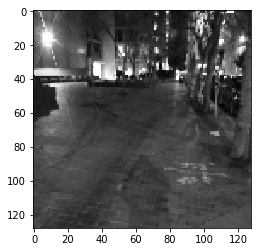

In [24]:
plt.imshow(image1, cmap='gray')

## Check code with small dataframe
It is much easier and faster to trouble shoot 20 images than thousands. The following section will create a mini dataframe of the first 20 samples and get the associated images.  Two pickle files of chunksize 10 are then generated to test the writing to pickle and reading pickle in functionality.

In [31]:
# Create mini dataframe and get images
df_mini = df_subset.iloc[0:20, :].copy()
df_mini.image = df_mini['media_url'].map(get_image)
df_mini.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month,image
0,7228536,2017-06-06 07:31:38,06/10/2017 12:26:23 PM,06/10/2017 12:26:23 PM,Closed,SES Graffiti Crew - Paint - Box - Sub Panel -...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,...,South of Market,SOUTHERN,37.774734,-122.400620,"(37.7747345, -122.40061951)",Mobile/Open311,http://mobile311.sfgov.org/reports/7228536/photos,2017,6,"[[235, 231, 231, 232, 232, 232, 232, 232, 230,..."
1,9848318,2018-11-25 13:15:00,11/25/2018 02:04:15 PM,11/25/2018 02:04:15 PM,Closed,Officer responded to request under CAD # 18329...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Civic - 5xcs051,...,Tenderloin,TENDERLOIN,37.783645,-122.410763,"(37.78364452, -122.41076323)",Mobile/Open311,http://mobile311.sfgov.org/reports/9848318/photos,2018,11,"[[49, 48, 49, 49, 49, 48, 51, 50, 47, 51, 49, ..."
2,9849482,2018-11-25 19:32:40,02/27/2019 09:30:07 PM,02/27/2019 09:30:07 PM,Closed,Per process - cases are closed 10 days after a...,Clear Channel - Transit Queue,Street and Sidewalk Cleaning,Transit_shelter_platform,Transit_shelter_platform,...,Rincon Hill,SOUTHERN,37.785531,-122.396656,"(37.7855311, -122.3966557)",Mobile/Open311,http://mobile311.sfgov.org/reports/9849482/photos,2018,11,"[[81, 89, 100, 198, 139, 111, 100, 111, 99, 10..."
3,9681555,2018-10-16 17:25:00,10/20/2018 04:24:00 PM,10/20/2018 04:24:00 PM,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Not_Offensive,...,Duboce Triangle,PARK,37.766496,-122.431225,"(37.76649554, -122.43122539)",Mobile/Open311,http://mobile311.sfgov.org/reports/9681555/photos,2018,10,"[[169, 175, 144, 142, 144, 153, 140, 168, 156,..."
4,9253531,2018-07-11 14:21:09,07/12/2018 06:33:00 PM,07/12/2018 06:33:00 PM,Closed,NaN,DPW Ops Queue,Litter Receptacles,Other_garbage_can_repair,NaN,...,Outer Sunset,TARAVAL,37.763896,-122.509486,"(37.76389604, -122.50948554)",Mobile/Open311,http://mobile311.sfgov.org/reports/9253531/photos,2018,7,"[[226, 221, 223, 224, 225, 210, 195, 208, 206,..."


In [32]:
# Confirm image size
df_mini.iloc[0]['image'].shape

(128, 128)

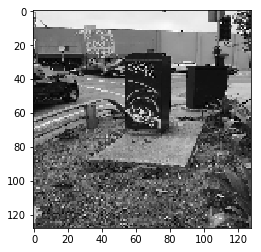

In [33]:
# Confirm an image
plt.imshow(df_mini.iloc[0]['image'], cmap='gray')

In [34]:
# Create 2 pickle files with 10 samples from the dataframe in each pickle
chunksize = 10
folder = 'bw_pickles/'
for i in range(0, df_mini.shape[0], chunksize):
    chunk = df_mini.iloc[i:min((i+chunksize), df_mini.shape[0])].copy(deep=True)
    chunk['image'] = chunk['media_url'].map(get_image)
    try:
        filename = folder + 'bw_mini_' + str(i) + '.gzde'
        chunk.to_pickle(filename, compression='gzip')
    except:
        print(str(i) + 'failed')

In [ ]:
# Read dataframe back in to check if it is as expected
df_test = pd.read_pickle('bw_pickles/bw_mini_10.gzde', compression='gzip')
df_test.head()

### Large scale 
Once the code was working with the small subset, run with the remaining data. If restarting due to an interruption, read in the selected_subset.csv file instead of starting from the beginning.

In [3]:
# If restarting kernel, read in the csv with just the selected 
# indices.  Not necessary if starting from beginning.
df_subset = pd.read_csv('selected_subset.csv', index_col=0)

In [4]:
df_subset.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month
0,7228536,2017-06-06 07:31:38,06/10/2017 12:26:23 PM,06/10/2017 12:26:23 PM,Closed,SES Graffiti Crew - Paint - Box - Sub Panel -...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,...,6.0,South of Market,SOUTHERN,37.774735,-122.400620,"(37.7747345, -122.40061951)",Mobile/Open311,http://mobile311.sfgov.org/reports/7228536/photos,2017,6
1,9848318,2018-11-25 13:15:00,11/25/2018 02:04:15 PM,11/25/2018 02:04:15 PM,Closed,Officer responded to request under CAD # 18329...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Civic - 5xcs051,...,6.0,Tenderloin,TENDERLOIN,37.783645,-122.410763,"(37.78364452, -122.41076323)",Mobile/Open311,http://mobile311.sfgov.org/reports/9848318/photos,2018,11
2,9849482,2018-11-25 19:32:40,02/27/2019 09:30:07 PM,02/27/2019 09:30:07 PM,Closed,Per process - cases are closed 10 days after a...,Clear Channel - Transit Queue,Street and Sidewalk Cleaning,Transit_shelter_platform,Transit_shelter_platform,...,6.0,Rincon Hill,SOUTHERN,37.785531,-122.396656,"(37.7855311, -122.3966557)",Mobile/Open311,http://mobile311.sfgov.org/reports/9849482/photos,2018,11
3,9681555,2018-10-16 17:25:00,10/20/2018 04:24:00 PM,10/20/2018 04:24:00 PM,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Not_Offensive,...,8.0,Duboce Triangle,PARK,37.766496,-122.431225,"(37.76649554, -122.43122539)",Mobile/Open311,http://mobile311.sfgov.org/reports/9681555/photos,2018,10
4,9253531,2018-07-11 14:21:09,07/12/2018 06:33:00 PM,07/12/2018 06:33:00 PM,Closed,NaN,DPW Ops Queue,Litter Receptacles,Other_garbage_can_repair,NaN,...,4.0,Outer Sunset,TARAVAL,37.763896,-122.509486,"(37.76389604, -122.50948554)",Mobile/Open311,http://mobile311.sfgov.org/reports/9253531/photos,2018,7


In [5]:
# Chunksize determines how many data points are in each pickle file.  With
# my internet connection, it took 14min to generate a pickle file with 1000 
# data points
chunksize = 1000
# Folder to save files 
folder = 'bw_pickles/'
# Update total size to total number of samples in df_subset
total_size = 120000
# Update start to next 
start = 0

for i in range(start, total_size, chunksize):
    # Create a smaller copy of the dataframe of size chunk and get image data
    chunk = df_subset.iloc[i:min((i+chunksize), total_size)].copy(deep=True)
    chunk['image'] = chunk['media_url'].map(get_image)
    # Print a failed notice if pickle file not generated
    try:
        filename = folder + 'bw_' + str(i) + '.gzde'
        chunk.to_pickle(filename, compression='gzip')
    except:
        print(str(i) + 'failed')

# Next Steps
From here I used the 311-Exploratory-Analysis to look at the categorical variables and 